[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1NNp9LjfZ3E_TN6Y_IZxLmbOrI5dPSWe3?usp=sharing)


<p align="center">
  <img src="https://i.imgur.com/7fqAQix.gif" alt="animated" />
</p>

# Step 0a: Dataset retrieval


If token is not manually uploaded in the first place...
```
from google.colab import files
files.upload() #upload kaggle.json
```

Install Kaggle, auth, then download dataset
```
# Install Kaggle from PyPI
!pip install -q kaggle

# Kaggle: auth
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

# Download dataset
!kaggle competitions download -c house-prices-advanced-regression-techniques

```

# Step 0b: Giới thiệu cuộc thi

- Độ đo RMSE
- Data mô tả
- Cách thức chấm

# Step 1: Exploratory data analysis

In [129]:
"""
Seed random state to reproduce result
Cite: https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
"""
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [130]:
"""
Thư viện dùng để EDA
"""
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats

In [131]:
"""
Bỏ thông báo lỗi để 'đẹp hơn' - nhưng 'khi làm' thì 'không nên'
"""
import warnings
warnings.filterwarnings('ignore')

In [132]:
# !cat data_description.txt

In [133]:
"""
Load data lên
"""
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [134]:
"""
Check shape
"""
'Test:', test_df.shape, 'Train:', train_df.shape

('Test:', (1459, 80), 'Train:', (1460, 81))

In [135]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [136]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [137]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [138]:
sample_submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [139]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Phân tích cột SalePrice cần dự đoán

In [140]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

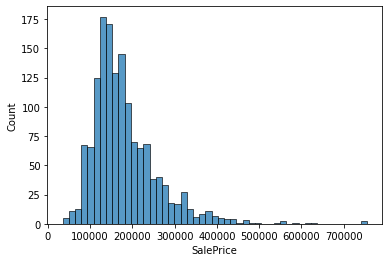

In [141]:
fig = sns.histplot(train_df['SalePrice'])

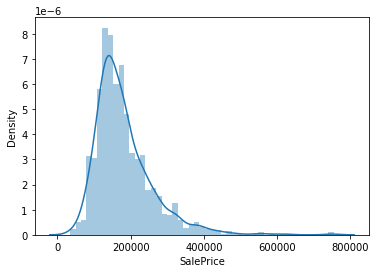

In [142]:
fig = sns.distplot(train_df['SalePrice'])

In [143]:
print(f"Skewness: {train_df['SalePrice'].skew()}")
print(f"Kurtosis: {train_df['SalePrice'].kurt()}")

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


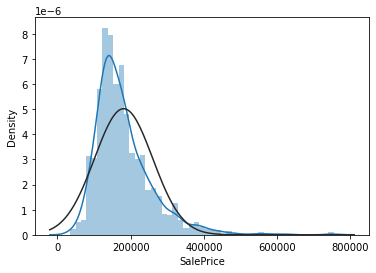

In [144]:
sns.distplot(train_df['SalePrice'], fit=stats.norm);

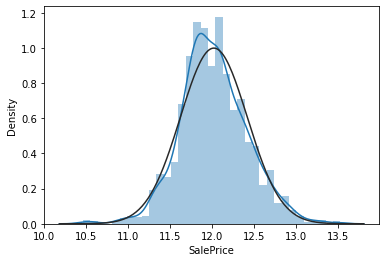

In [145]:
sns.distplot(np.log(train_df['SalePrice']), fit=stats.norm);

In [146]:
# train_label = train_df['SalePrice']
# train_df.drop(['SalePrice'],axis=1,inplace=True)

#Step 2: Data cleaning

## Step 2a: Xử lí outliers

## Step 2b: Xử lí missing value

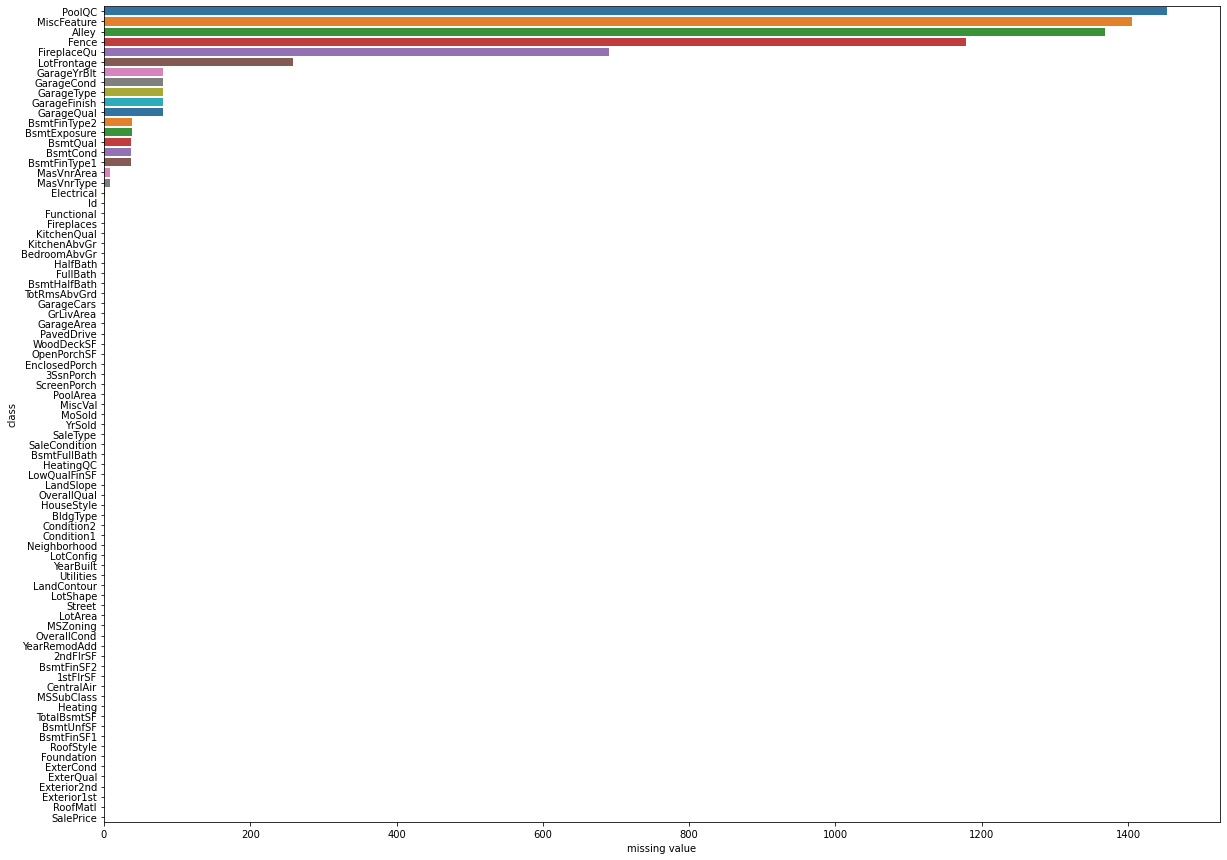

In [147]:
"""
Kiem tra missing value
"""
train_cols = {'class': [], 'missing value': []}
for col in train_df.columns.values:
  train_cols['class'].append(col)
  train_cols['missing value'].append(train_df[col].isnull().sum())

train_mis_data = pd.DataFrame.from_dict(train_cols)
# train_mis_data
train_mis_data.sort_values(by='missing value',inplace=True,ascending=False)
fig, ax = plt.subplots(figsize=(20,15))
sns.barplot(ax=ax,y='class',x='missing value',data=train_mis_data,palette="tab10");
# ax.set_figure((100,100))

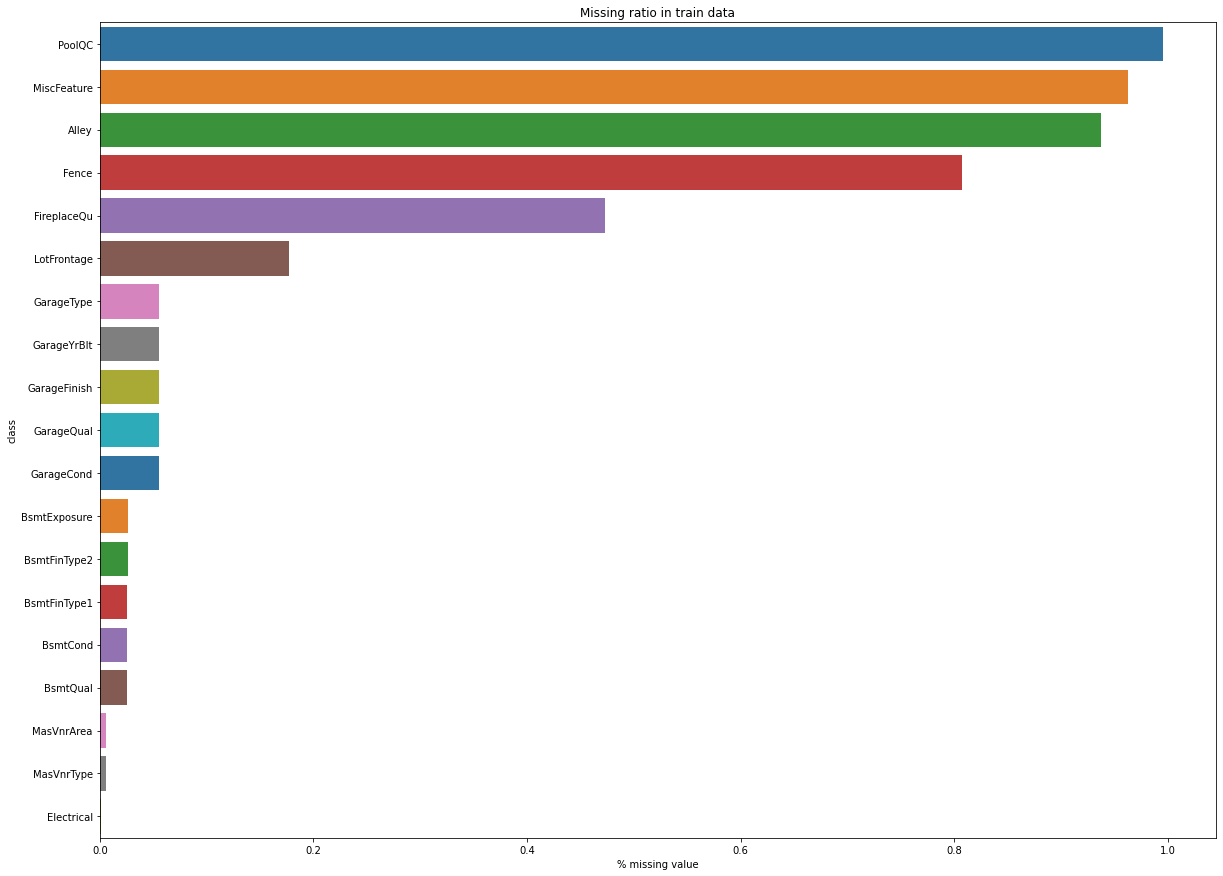

In [148]:
"""
Kiem tra missing value percentage
"""
train_cols = {'class': [], '% missing value': []}

missing_features =[f for f in train_df.columns if train_df[f].isnull().sum()>0]
for feature in missing_features:
    train_cols['class'].append(feature)
    train_cols['% missing value'].append(train_df[feature].isnull().mean())


train_mis_data = pd.DataFrame.from_dict(train_cols)
# train_mis_data
train_mis_data.sort_values(by='% missing value',inplace=True,ascending=False)
fig, ax = plt.subplots(figsize=(20,15))
sns.barplot(ax=ax,y='class',x='% missing value',data=train_mis_data,palette="tab10")
ax.set_title("Missing ratio in train data");

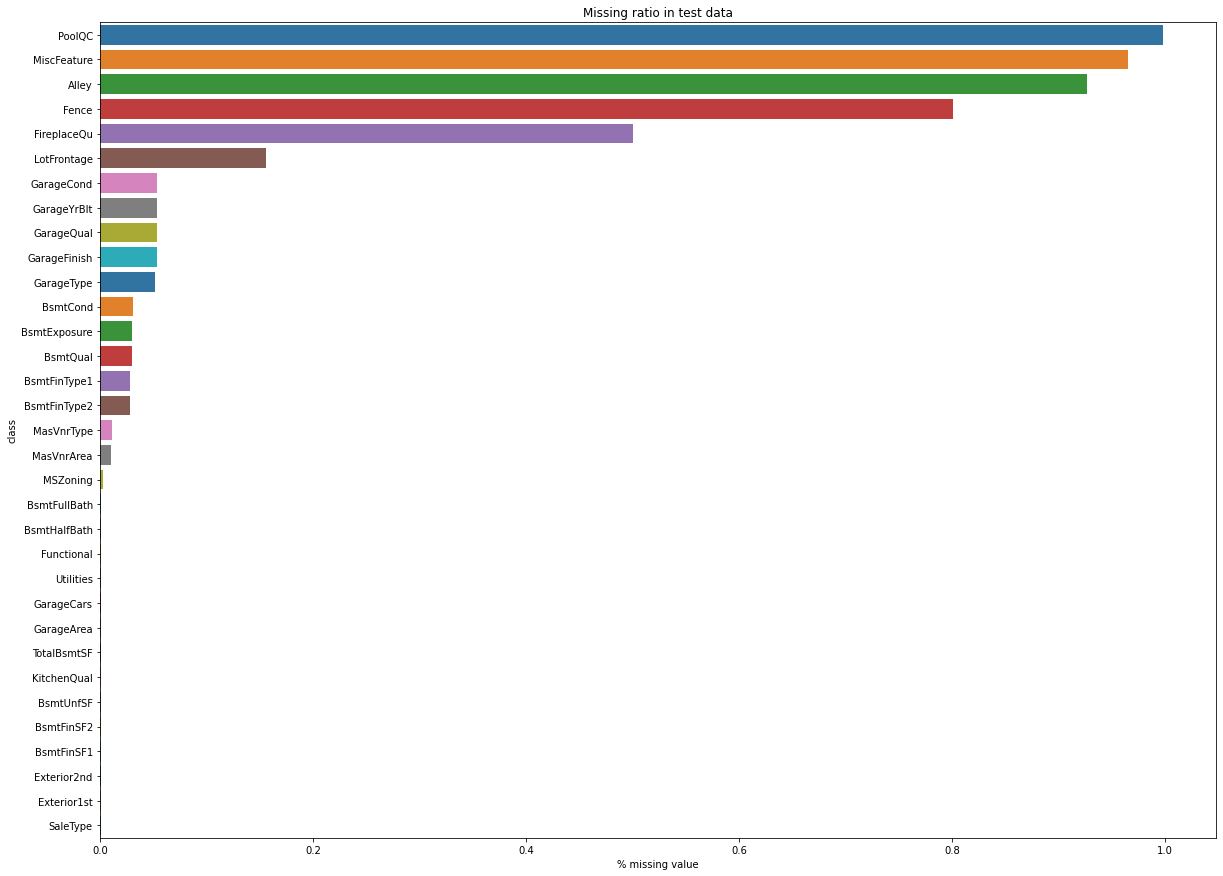

In [149]:
"""
Kiem tra missing value percentage tren tap test
"""
test_cols = {'class': [], '% missing value': []}

missing_features =[f for f in test_df.columns if test_df[f].isnull().sum()>0]
for feature in missing_features:
    test_cols['class'].append(feature)
    test_cols['% missing value'].append(test_df[feature].isnull().mean())


test_mis_data = pd.DataFrame.from_dict(test_cols)
test_mis_data.sort_values(by='% missing value',inplace=True,ascending=False)
fig, ax = plt.subplots(figsize=(20,15))
sns.barplot(ax=ax,y='class',x='% missing value',data=test_mis_data,palette="tab10")
ax.set_title("Missing ratio in test data");

![](https://i.imgur.com/QLA5kFl.png)

In [150]:
features_missing_value =[col for col in train_df.columns if train_df[col].isnull().sum()>0]
numerical_cols = [col for col in train_df.columns if train_df[col].dtype != 'O']
temporal_cols = [col for col in numerical_cols if 'Year' in col or 'Yr' in col]
discrete_cols = [col for col in numerical_cols if len(train_df[col].unique()) <=25 and col not in temporal_cols + ['Id']]

continuous_cols = [col for col in numerical_cols if col not in discrete_cols + temporal_cols + ['Id']]
categorial_cols = [col for col in train_df.columns if train_df[col].dtypes == 'O']

In [151]:
categorial_missing_value = [col for col in categorial_cols if train_df[col].isnull().sum() > 0]

### Fill các cột missing ở cate bằng giá trị Missing - vì một số trường là có nghĩa

TODO: GIẢI THÍCH

In [152]:
for col in categorial_missing_value:
    train_df[col].fillna('Missing', inplace=True)

In [153]:
categorial_missing_value = [col for col in categorial_cols if test_df[col].isnull().sum() > 0]
for col in categorial_missing_value:
    test_df[col].fillna('Missing', inplace=True)

### Fill các cột missing ở dạng numerical bằng giá trị mean của tập train

TODO: Vì sao?

In [154]:
numerical_missing_value = [col for col in numerical_cols if train_df[col].isnull().sum() > 0]
for col in numerical_missing_value:
      train_df[col].fillna(train_df[col].median(), inplace=True)

In [155]:
numerical_cols.remove("SalePrice")
numerical_missing_value = [col for col in numerical_cols if test_df[col].isnull().sum() > 0]
for col in numerical_missing_value:
      test_df[col].fillna(train_df[col].median(), inplace=True)

### Skewing data

TODO: Giải thích log và cách skew!

In [156]:
skew_cols = ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']
for col in skew_cols:
    train_df[col] = np.log(train_df[col])

In [157]:
skew_cols = ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea']
for col in skew_cols:
    test_df[col] = np.log(test_df[col])

# Step 3: Feature Selection

In [158]:
train_data = train_df.copy()
test_data = test_df.copy()

## Step 3a: Feature analysis

## Step 3b: Feature drop

## Step 3c: Feature extraction

# Step 4: Modeling

In [159]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import ElasticNet, Lasso

In [160]:
data = pd.concat([train_data,test_data], axis=0)
train_records = train_data.shape[0]
for col in categorial_cols:
    # One hot encoding
    dummy = pd.get_dummies(data[col])
    for col_name in dummy.columns:
        dummy.rename(columns={col_name: f"{col}_{col_name}"}, inplace=True)
    data = pd.concat([data, dummy], axis = 1)
    data.drop([col], axis = 1, inplace=True)
train_data = data.iloc[:train_records, :]
test_data = data.iloc[train_records:, :] 

In [161]:
scaling_cols = [col for col in train_data.columns if col not in ['Id', 'SalePrice']]

scaler = StandardScaler()
scaler.fit(train_data[scaling_cols])
X_train = scaler.transform(train_data[scaling_cols])
X_test = scaler.transform(test_data[scaling_cols])

y_train = train_data['SalePrice']

In [162]:
left = train_data[['Id','SalePrice']]
right = pd.DataFrame(X_train)

left.reset_index(drop=True, inplace=True)
right.reset_index(drop=True, inplace=True)
X = pd.concat([left, right], axis=1)

## Step 4a: Single model

In [164]:
def rmse(y_train, y_pred):
    return np.sqrt(mean_squared_error(y_train, y_pred))

### Lasso Regression

In [165]:
lasso = Lasso(alpha =0.0005, random_state=seed_value)

In [166]:
model = lasso.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(("RMSE in train: ", rmse(y_train,y_pred)))

('RMSE in train: ', 0.09220516009152636)


## Step 4b: Stacking/Essemble

TODO: Múa!

# Submit

In [167]:
def make_submission(model):
  try:
    prediction = np.exp(model.predict(X_test))
    sub = pd.DataFrame()
    sub['Id'] = test_df['Id']
    sub['SalePrice'] = prediction
    sub.to_csv('submission.csv',index=False)
    return True
  except:
    return False

In [168]:
make_submission(model)

True